### This program is designed for spherical phase-unwrapping

In [28]:
import numpy as np
from scipy import ndimage
import cv2   as cv
import matplotlib
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects as rso
from mpl_toolkits.mplot3d import axes3d

from getstartpoints import getstartpoints as gsp
from PhaseReduce import PhaseReduce as pr

plt.style.use('default')
matplotlib.use('TkAgg')

Import the interference image in gray forum

(<matplotlib.image.AxesImage at 0x20000571cc0>, Text(0.5, 1.0, 'origin'))

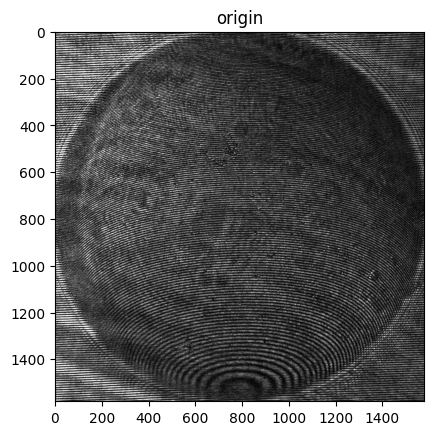

In [29]:
origin = cv.imread('19_middle.png', 0)
plt.imshow(origin, cmap='gray'), plt.title('origin')

FFT  
Seek out the zero & first peak of spectrum

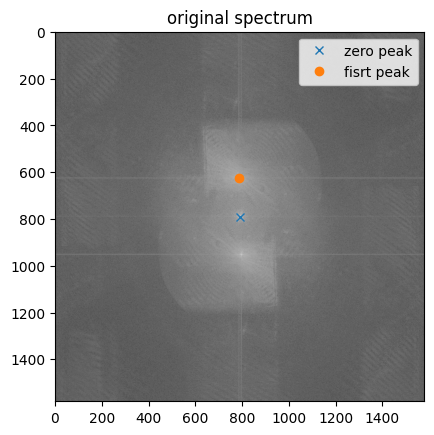

In [30]:
C = np.fft.fftshift(np.fft.fft2(origin))
plt.imshow(20*np.log(np.abs(C)), cmap='gray'), plt.title('original spectrum')

Cabs = np.abs(C)
Cpeak = ndimage.maximum_filter(np.abs(C), size=3) # 极大值滤波器寻找局部极值
Cpeak = Cabs[Cabs-Cpeak == 0]
Cpeak = sorted(Cpeak, reverse=True)
[loc0, loc1] = [np.argwhere(Cabs == Cpeak[0])[0], np.argwhere(Cabs == Cpeak[1])[0]]
plt.plot(loc0[1], loc0[0], 'x')
plt.plot(loc1[1], loc1[0], 'o')
plt.legend(['zero peak','fisrt peak'])

Calculate the distance between two peaks  
Design a Hann window

Text(0.5, 1.0, 'whole window')

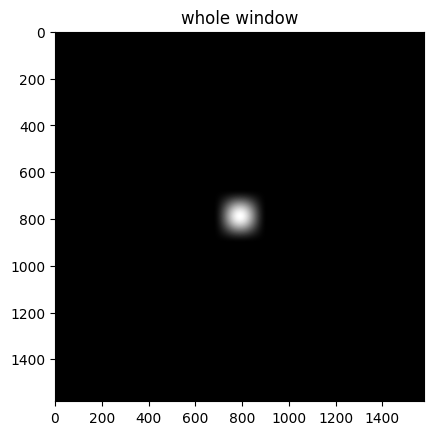

In [31]:
d0 = round(np.sqrt((loc0[1]-loc1[1])**2 + (loc0[0]-loc1[0])**2)) 
windowlen = round(np.sqrt(2) * d0)                               
core = np.hanning(windowlen) * np.hanning(windowlen).reshape(-1, 1) 

# 将hann窗扩展到等大小，并滚动至中心
whole_window = np.r_[core, np.zeros((C.shape[0]-core.shape[0], core.shape[1]))]
whole_window = np.c_[whole_window, np.zeros((C.shape[0], C.shape[1]-core.shape[1]))]
whole_window = np.roll(whole_window, round(C.shape[0]/2-core.shape[0]/2), axis=0)
whole_window = np.roll(whole_window, round(C.shape[1]/2-core.shape[1]/2), axis=1)
plt.imshow(whole_window, cmap='gray')
plt.title('whole window')

Scroll the first sprctral peak to center  
Make a dot product between it and the Hann window

(<matplotlib.image.AxesImage at 0x20000472ef0>,
 Text(0.5, 1.0, 'filted spectrum'))

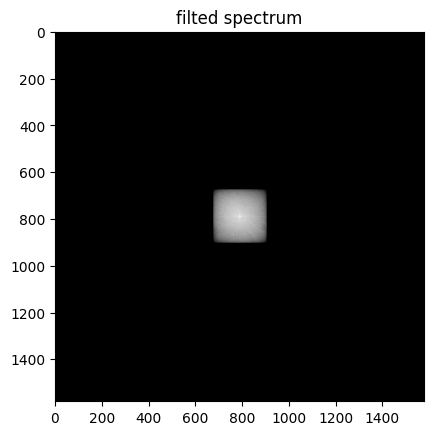

In [32]:
C = np.roll(C, loc0[0]-loc1[0], axis=0)
C = np.roll(C, loc0[1]-loc1[1], axis=1)
C = C * whole_window
plt.imshow(20*np.log(np.abs(C)+1), cmap='gray'), plt.title('filted spectrum')

IFFT the spctrum to rad angle matrix  
Change data to uint8  
Replace LoG with Canny

(<AxesSubplot:title={'center':'angle edge'}>,
 Text(0.5, 1.0, 'angle edge'))

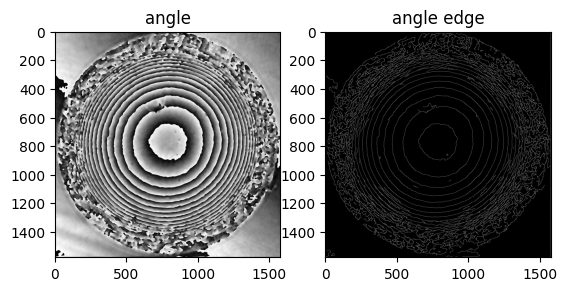

In [33]:
Angle = np.angle(np.fft.ifft2(np.fft.ifftshift(C)))
Angle = np.uint8((Angle - Angle.min()) / (Angle.max() - Angle.min()) * 255)
Angle1 = cv.medianBlur(Angle, 3)
plt.subplot(121), plt.imshow(Angle, cmap='gray'), plt.title('angle')
plt.subplot(122), plt.imshow(cv.Canny(Angle, 50, 200), cmap='gray'), plt.title('angle edge')

Gain seeds

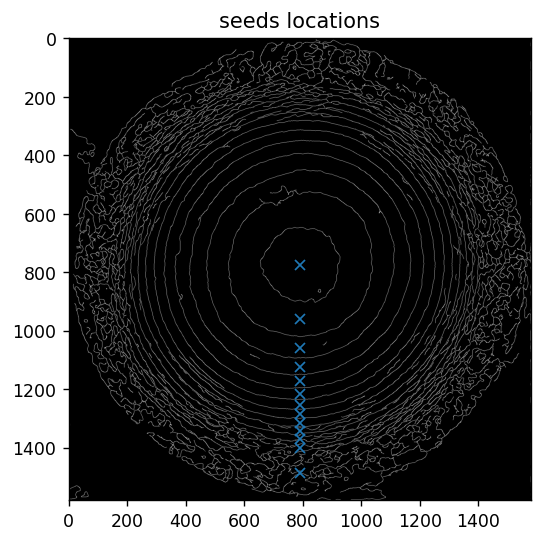

In [34]:
plt.imshow(cv.Canny(Angle, 50, 200), cmap='gray'), plt.title('seeds locations')
firstpoint = plt.ginput(1)
[startCols, startRows] = gsp(firstpoint[0][1], firstpoint[0][0], \
    rso(cv.Canny(Angle, 250, 300), 300, 2))
plt.plot(startRows, startCols, 'x') # 起始点在轮廓图上叠加显示

Remove small edge projects

(<matplotlib.image.AxesImage at 0x20000fb3130>, Text(0.5, 1.0, 'cleared edge'))

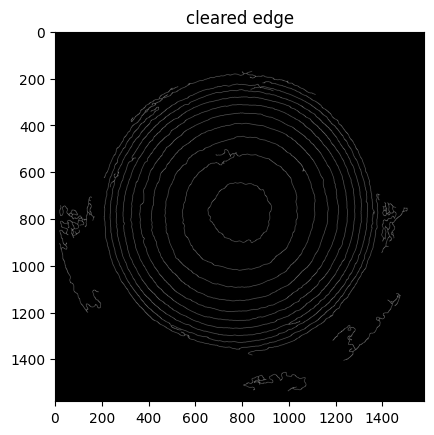

In [35]:
EDGE = np.array(cv.Canny(Angle, 50, 200)) != 0 # 配合rso转为bool型
EDGE1 = np.uint8(rso(EDGE, 800, 2))            # 配合cv.dilate转为uint8
plt.imshow(EDGE1, cmap='gray'), plt.title('cleared edge')

Sew the edge gaps

(<matplotlib.image.AxesImage at 0x20007870e80>,
 Text(0.5, 1.0, 'strengthened edge'))

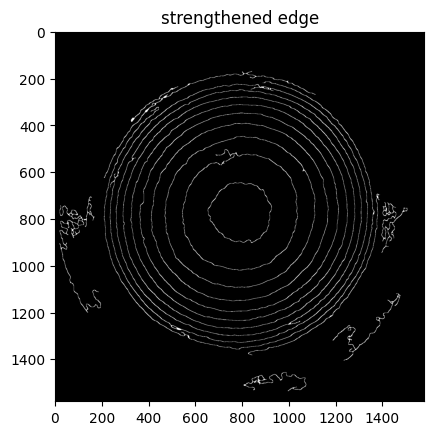

In [36]:
se1 = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
se2 = cv.getStructuringElement(cv.MORPH_CROSS,(3, 3))
se3 = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
EDGE2 = cv.erode(cv.erode(cv.dilate(EDGE1, se1), se3), se2) # 将边缘缺口弥合
plt.imshow(EDGE2, cmap='gray'), plt.title('strengthened edge')

Unwrap the phase by edge and seeds

(<matplotlib.image.AxesImage at 0x20000fd26e0>,
 Text(0.5, 1.0, 'unwrapped phase'))

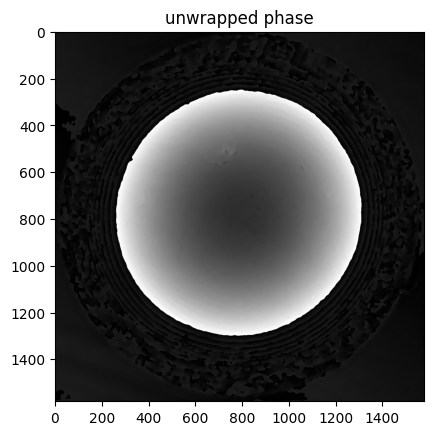

In [37]:
unwrapped = pr(Angle, startCols[:8], startRows[:8], EDGE2) # 相位解包裹
plt.imshow(unwrapped, cmap='gray'), plt.title('unwrapped phase')

Display in 3D surface

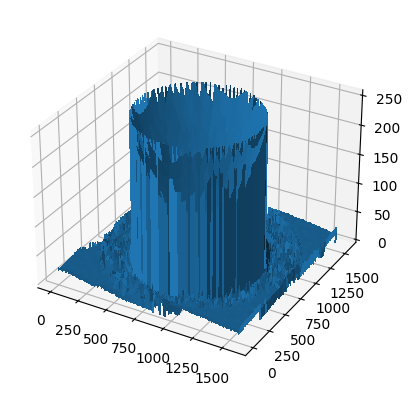

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = range(unwrapped.shape[0])
Y = range(unwrapped.shape[1])

X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, unwrapped, linewidth = 0, antialiased = False)